# 흐린 사진을 선명하게

![img](http://storage.enuri.info/pic_upload/knowbox2/202003/092406573202003036c7b1d5a-15e2-4495-8672-92c8303187df.jpeg)

위 사진은 유관순 열사의 고화질 복원 사진입니다.

이미지 생성형 기술이 효과적으로 사용되는 사례로 저해상도의 이미지를 고해상도 이미지로 변환하는 Super Resolution 을 꼽을 수 있습니다. 특히 GAN 관련 기술이 일반적인 CNN 기술보다 훨씬 정밀한 고해상도 이미지를 생성해 내는데 효과적입니다. 하지만 고화질의 이미지를 생성해 내는 GAN 모델을 학습하는 것은 오랜 시간이 소요되는 과정입니다. 오늘은 모델학습 과정 자체보다는 모델의 구조와 특성, 그리고 잘 학습된 모델을 활용한 고해상도 변환을 체험하는 데 보다 중점을 두어 진행하게 될 것입니다.



## 데이터 셋 다운로드

이번 학습에서 사용할 데이터를 먼저 다운로드 받도록 하겠습니다. `tensorflow-datasets` 라이브러리가 설치되어있지 않다면 아래 명령어를 통해 설치해주세요.

```bash
$ pip install tensorflow-datasets
```

그리고 아래 두 줄의 코드를 실행하여 데이터를 다운로드 받습니다.


In [1]:
import tensorflow_datasets as tfds
tfds.load("div2k/bicubic_x4")

EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Shuffling and writing examples to /home/aiffel0039/tensorflow_datasets/div2k/bicubic_x4/2.0.0.incompleteWGOWHC/div2k-train.tfrecord


Shuffling and writing examples to /home/aiffel0039/tensorflow_datasets/div2k/bicubic_x4/2.0.0.incompleteWGOWHC/div2k-validation.tfrecord


Dataset div2k downloaded and prepared to /home/aiffel0039/tensorflow_datasets/div2k/bicubic_x4/2.0.0. Subsequent calls will reuse this data.


{'train': <PrefetchDataset shapes: {hr: (None, None, 3), lr: (None, None, 3)}, types: {hr: tf.uint8, lr: tf.uint8}>,
 'validation': <PrefetchDataset shapes: {hr: (None, None, 3), lr: (None, None, 3)}, types: {hr: tf.uint8, lr: tf.uint8}>}

## Super Resolution이란?

"Super Resolution"에서 *Resolution*이란 무엇을 말하는 걸까요? 아래 글을 먼저 읽어봅시다.

- [참고 : 모니터의 핵심, 디스플레이 스펙 따라잡기](http://blog.lgdisplay.com/2014/03/%eb%aa%a8%eb%8b%88%ed%84%b0-%ed%95%b5%ec%8b%ac-%eb%94%94%ec%8a%a4%ed%94%8c%eb%a0%88%ec%9d%b4%ec%9d%98-%ec%8a%a4%ed%8e%99-%eb%94%b0%eb%9d%bc%ec%9e%a1%ea%b8%b0-%ed%95%b4%ec%83%81%eb%8f%84/)
- [참고 : 그림으로 쉽게 알아보는 HD 해상도의 차이!](https://blog.lgdisplay.com/2014/07/%EA%B7%B8%EB%A6%BC%EC%9C%BC%EB%A1%9C-%EC%89%BD%EA%B2%8C-%EC%95%8C%EC%95%84%EB%B3%B4%EB%8A%94-hd-%ED%95%B4%EC%83%81%EB%8F%84%EC%9D%98-%EC%B0%A8%EC%9D%B4/)

사실 해상도에 대해 정확히 설명할 때에는 픽셀 수 뿐만 아니라 픽셀의 크기 등을 고려해야 하지만, 오늘의 내용에서는 다루지 않겠습니다. 

영상을 이용해 어떠한 일을 하는지에 따라 영상 정보의 손실을 최대한 줄이기 위해 고해상도 영상을 필요로할 수 있으며, 우리가 흔히 유튜브 영상을 시청하는 경우에도 고해상도 영상을 선호합니다.

![img](https://aiffelstaticprd.blob.core.windows.net/media/original_images/e-22-2.youtube_resolution.png)

그렇지만 고해상도 영상은 저해상도 영상보다 크기가 훨씬 크기 때문에 인터넷 환경에 따라 전송에 많은 시간이 필요합니다. 고해상도의 youtube 영상을 보려다 중간중간 잦은 로딩과 버벅임으로 답답했던 경험은 한번쯤 있을 것입니다. 이 경우 쉽게 해결할 수 있는 방법 중 하나는 해상도를 그냥 포기하는 것이죠.. (😂)


이런 경우에 사용할 수 있는 방법이 오늘 배울 **Super Resolution**입니다. Super Resolution이란 <u>저해상도의 영상을 고해상도 영상으로 변환하는 작업 또는 그러한 과정</u>을 말합니다. 우리 말로 번역해서 "초해상화"라는 용어로 사용되곤 합니다. Super Resolution은 수많은 컴퓨터 비전 연구 분야 중 하나로 고해상도 디스플레이의 발전에 따라 지금까지 많은 관심을 받아왔습니다.

저해상도의 Youtube 영상을 빠르게 받아 Super Resolution 기술로 고해상도 영상을 생성할 수 있다면 최악의 인터넷 환경에서도 충분히 고해상도의 영상을 시청할 수 있습니다. 


> Super Resolution 활용 사례

한번 활용 사례를 살펴봅시다.

![Img](https://aiffelstaticprd.blob.core.windows.net/media/images/e-22-3.white_tower.max-800x600.png)

우리나라에서 가장 대표적으로 꼽히는 super resolution 활용 사례는 <하얀거탑>이라는 드라마의 리마스터링입니다. 2007년 처음 방송 당시 HD 화질로 송출되었던 <하얀거탑>은 UHD 화질로 향상되어 2018년 재방송 되었습니다. 여기에는 Super Resolution 기술 뿐만 아니라 노이즈 제거 등의 여러 작업을 거쳤다고 합니다. 자세한 내용은 [하얀거탑 리마스터링 제작기](http://tech.kobeta.com/%ED%95%98%EC%96%80%EA%B1%B0%ED%83%91-uhd-%EB%A6%AC%EB%A7%88%EC%8A%A4%ED%84%B0%EB%A7%81-%EC%A0%9C%EC%9E%91%EA%B8%B0/)를 읽어보세요!

![img](https://aiffelstaticprd.blob.core.windows.net/media/images/e-22-4.cctv.max-800x600.png)

CCTV는 대상의 거리가 멀어짐에 따라 획득한 화면의 해상도가 저하되는 현상이 발생합니다. 정보 손실이 많은 저해상도 영상을 활용하면 차량의 번호판이나 얼굴을 인식하는데 큰 어려움을 겪거나 심지어는 인식 자체가 불가능해질 수 있습니다. 이런 문제를 극복하기 위해 Super Resolution 기술을 적용하여 고해상도 이미지를 생성해내는 연구가 진행되고 있습니다.




## Super Resolution을 어렵게 만드는 요인들

이번에는 Super Resolution을 진행하여 좋은 결과를 얻어내도록 신경망을 학습시키는데 몇가지 어려운 시험들에 대해 알아보겠습니다.

![img](https://aiffelstaticprd.blob.core.windows.net/media/images/e-22-6.hard_1.max-800x600.png)

첫 번째 어려운 점은 하나의 저해상도 이미지에 대해 여러 개의 고해상도 이미지가 나올 수 있다는 것입니다. 위 그림은 1개의 저해상도 이미지(상단 이미지)에 대응하는 3개의 고해상도 이미지(하단 이미지)를 나타냈습니다. 3개의 고해상도 이미지 사이에서는 눈으로 볼 때 거의 차이를 나타내지 않지만, 아래 확대한 이미지를 보면 세부적으로 픽셀의 값이 각각 다른 것을 알 수 있죠. 하나의 저해상도 이미지를 고해상도 이미지로 만드는데 매우 다양한 경우의 수가 있다는 것은 Super Resolution이 가진 큰 특징이며, 이러한 문제를 **ill-posed (inverse) problem**이라 부릅니다.

일반적으로 Super Resolution 모델을 학습시키기 위한 데이터를 구성하는 과정은, 먼저 고해상도 이미지를 준비하고 특정한 처리과정을 거쳐 저해상도 이미지를 생성하며, 생성된 저해상도 이미지를 입력으로 원래의 고해상도 이미지를 복원하도록 학습을 진행합니다.

![img](https://aiffelstaticprd.blob.core.windows.net/media/original_images/e-22-7.hard_2.png)

두 번째 어려운 점은 Super Resolution 문제의 **복잡도**입니다. 위 그림은 2x2 크기의 이미지를 이용해 3x3, 4x4, 5x5 크기의 이미지로 Super Resolution 하는 과정을 간략하게 나타냈습니다. 녹색으로 나타난 2x2 이미지 픽셀을 입력으로 3x3 크기의 이미지 만드는 경우 새롭게 생성해야 하는 정보는 최소 5개 픽셀(회색)이며, 4x4의 경우 12개, 5x5의 경우 21개의 정보를 생성해야 합니다. 원래 가진 제한된 정보(녹색 픽셀)만을 이용해 많은 정보(회색 픽셀)를 만들어내는 과정은 매우 복잡하며 그만큼 *잘못된 정보를 만들어 낼 가능성 또한 높습니다.* 이 문제는 원래 가진 이미지의 해상도 보다 더욱 더 높은 해상도로 Super Resolution 할수록 점점 심해집니다.

![img](https://aiffelstaticprd.blob.core.windows.net/media/images/e-22-8.hard_3.max-800x600.png)

위 이미지의 첫 번째 및 네 번째 이미지는 저해상도 및 고해상도 이미지를 나타내며, 두 번째 및 세 번째 이미지는 각각 다른 딥러닝 모델을 이용해 Super Resolution 하여 생성한 결과 이미지입니다. 딥러닝 방법을 사용한 결과(두 번째 및 세 번째 이미지)를 비교한다면, 시각적으로 어떤 이미지가 더 고해상도에 가까운가요? 대부분 결과 2 이미지가 분명 더욱 세밀한 정보를 잘 표현하여 해상도가 높다고 생각할 수 있습니다. 많은 Super Resolution 연구에서 사용되는 두 개의 정량적 평가 결과가 두 번째 및 세 번째 이미지 제목에 나타나 있습니다. 결과 2의 이미지에 세밀한 정보가 잘 표현되었다고 생각했지만 실제 평가 결과는 결과 1 이미지에 쓰인 숫자가 더 높은 것을 확인할 수 있습니다. 이 평가 척도는 각각 높을수록 더 원본 이미지와 비슷함을 말하며, 정량적으로 결과 1이 더 좋은 결과라는 뜻입니다. (이러한 평가 척도에 대해서는 이후 단계에서 다루겠습니다) 마지막으로 Super Resolution을 수행하는데 어려운 점은 위 그림과 같이 결과를 평가하는 데 있어 흔히 사용되는 *정량적 평가 척도와 사람이 시각적으로 관찰하여 내린 평가가 잘 일치하지 않는다*는 것입니다.

## 가장 쉬운 Super Resolution - Interpolation

Super Resolution을 수행하는 가장 쉬운 방식은 **Interpolation**을 이용하는 것입니다. 아래 링크의 글을 먼저 읽어봅시다.

- [선형보간법(linear interpolatioin)과 삼차보간법(cubic interpolation) 제대로 이해하기](https://bskyvision.com/789)
- [Bilinear interpolation 예제](http://blog.naver.com/dic1224/220882679460)

감이 오시나요?

이번에는 opencv 라이브러리를 이용해 interpolation을 적용해 봅시다. 적용할 이미지는 scikit-image에서 제공하는 예제 이미지를 사용하겠습니다. 만약 두 라이브러리가 설치되어 있지 않다면 아래와 같이 먼저 설치해주세요.

```bash
$ pip install opencv-python
$ pip install scikit-image
```

아래 코드를 이용해 scikit-image에 살고있는 고양이를 잠시 데려옵니다.🐱




(300, 451, 3)


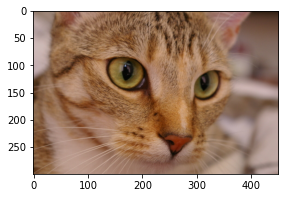

In [2]:
from skimage import data
import matplotlib.pyplot as plt

hr_image = data.chelsea() # skimage에서 제공하는 예제 이미지를 불러옵니다.
hr_shape = hr_image.shape[:2]

print(hr_image.shape) # 이미지 크기 출력

plt.figure(figsize = (6, 3))
plt.imshow(hr_image)

이 고양이 이미지의 크기는 (세로 픽셀 수 x 가로 픽셀 수 x 채널 수) 가 [300 x 451 x 3] 으로 확인되네요. Interpolation을 통해 고양이를 매우 쉽게 Super Resolution 해보겠습니다.

우선 불러온 고양이가 꽤나 선명하기 때문에 일부러 크기를 줄여 저해상도로 낮춰보겠습니다. opencv 라이브러리의 `resize()`를 이용해 이미지의 크기를 조절할수 있습니다. 아래 코드에서는 고양이를 '100 x 150 x 3' 크기로 줄입니다. `dsize`의 설정 값에 따라 크기를 조절하는데, 주의할 점은 변환하고자 하는 이미지의 크기를 (가로 픽셀 수, 세로 픽셀 수) 로 지정해줘야 합니다.

(100, 150, 3)


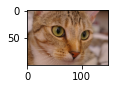

In [3]:
import cv2
lr_image = cv2.resize(hr_image, dsize=(150, 100)) # (가로 픽셀 수, 세로 픽셀 수)

print(lr_image.shape)

plt.figure(figsize=(3, 1))
plt.imshow(lr_image)

작아진 고양이 이미지로 Interpolation 방법을 적용해 Super Resolution을 시도해보겠습니다. `resize()`내의 `interpolation` 설정에 따라 적용 방법을 조절할 수 있습니다. 아래 코드는 이전에 간략하게 알아보았던 bilinear 및 bicubic interpolation을 적용해 이미지를 '400 x 600 x 3' 크기로 크게 변환하는 예제입니다.



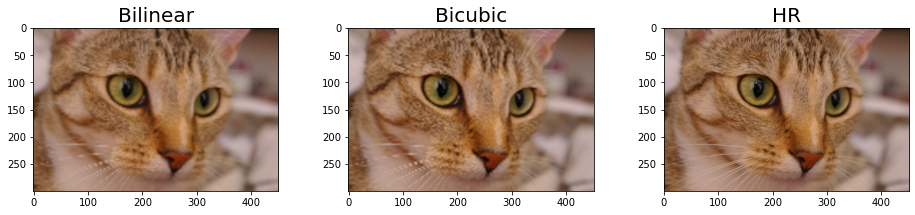

In [4]:
bilinear_image = cv2.resize(
    lr_image,
    dsize = (451, 300), # (가로 픽셀 수, 세로 픽셀 수)
    interpolation = cv2.INTER_LINEAR # bilinear interpolation 적용
)

bicubic_image = cv2.resize(
    lr_image,
    dsize = (451, 300),
    interpolation = cv2.INTER_CUBIC # bicubic interpolation 적용
)

images = [bilinear_image, bicubic_image, hr_image]
titles = ["Bilinear", "Bicubic", "HR"]

plt.figure(figsize=(16, 3))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1, 3, i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

Bilinear 및 bicubic interpolation을 적용한 이미지와 원래 고해상도 이미지(위 그림의 HR)를 시각화 했습니다. 이미지가 작아 시각적으로 해상도에 큰 차이가 없어보입니다. 아래 코드를 이용해 특정 부분을 잘라내어 시각화 해봅시다.



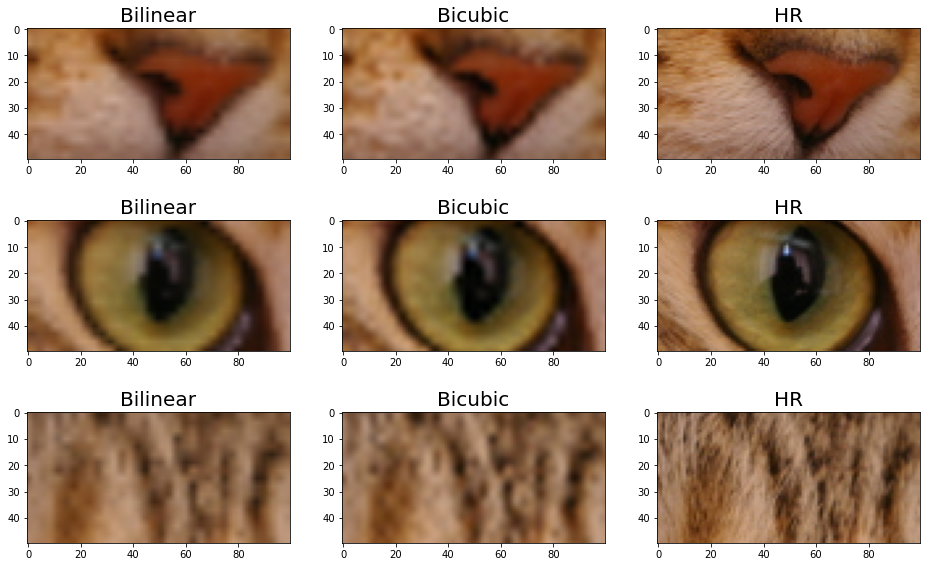

In [5]:
# 특정 영역을 잘라낼 함수를 정의합니다.
def crop(image, left_top, x=50, y=100):
    return image[left_top[0]:(left_top[0] + x), left_top[1]:(left_top[1] + y), :]

# 잘라낼 영역의 좌표를 정의합니다.
left_tops = [(220, 200)] * 3 + [(90, 120)] * 3 + [(30, 200)] * 3

plt.figure(figsize = (16, 10))
for i, (image, left_top, title) in enumerate(zip(images*3, left_tops, titles*3)):
    plt.subplot(3, 3, i+1)
    plt.imshow(crop(image, left_top))
    plt.title(title, fontsize=20)

Interpolation 방법을 이용한 Super Resolution 결과는 어떤가요? 이미지만 크게 만들어줄 뿐 세밀한 정보는 거의 찾아볼 수 없는 것을 확인할 수 있습니다.

위와 같은 interpolation 방법은 많은 딥러닝 기반 Super Resolution 연구에서 결과를 비교 하기 위해 수행됩니다. 이제부터는 딥러닝 기반 Super Resolution에 대해 간략히 알아보고 실험해 보겠습니다. 그리고 방금 수행한 interpolation 방법과 비교하여 딥러닝을 사용하는 것이 얼마나 성능이 좋은지 한번 직접 느껴봅시다!😆

## Deep Learning을 이용한 Super Resolution (1) SRCNN

**SRCNN**은 2014년 발표된 *Image Super-Resolution Using Deep Convolutional Networks* 논문에서 사용되었습니다. Super Resolution Convolutional Neural Networks의 앞글자를 따서 **SRCNN**이라고 불리며, 매우 간단한 모델 구조를 사용했음에도 기존 결과에 비해 큰 성능 향상을 이뤄냈습니다. 지금 이 연구를 보면 너무 간단해 보이지만, Super Resolution 문제에 가장 처음 딥러닝을 적용한 연구로써 이 후 많은 딥러닝 기반의 Super Resolution 연구에 큰 영향을 준 정말 멋진 작품(?)입니다🙂

아래 그림이 SRCNN의 구조입니다. 

![img](https://aiffelstaticprd.blob.core.windows.net/media/images/e-22-9.srcnn.max-800x600.png)

가장 먼저 저해상도 이미지(그림의 LR)를 bicubic interpolation 하여 원하는 크기로 이미지를 늘립니다. SRCNN은 이 이미지(그림의 ILR)를 입력으로 사용합니다. 이 후 3개의 convolutional layer를 거쳐 고해상도 이미지를 생성해 냅니다. 생성된 고해상도 이미지와 실제 고해상도 이미지 사이의 차이를 역전파 하여 신경망의 가중치를 학습합니다. 최근 발표되는 수 백개 이상의 convolutional layer를 갖는 CNN과 비교하면 SRCNN은 매우 간단합니다.

SRCNN이 발표된 지 꽤 오랜 시간이 흘렀고, 딥러닝 기반 Super Resolution 분야에서 대표적인 연구로 꼽히는 만큼 이 연구에 대해 정리된 자료들이 매우 많습니다. 아래 SRCNN에 대해 설명한 참고 자료를 읽고 질문에 답해봅시다. (Experiments 이전까지만 보시면 됩니다)

- [[ 논문리뷰 ] SRCNN - Image Super-Resolution Using Deep Convolutional Networks](https://d-tail.tistory.com/6)

SRCNN은 세가지 연산으로 구성됩니다. 

1. **Patch Extraction and Representation** : 저해상도 이미지에서 patch를 추가한다
2. **Non-linear mapping** : Patch를 다른 차원의 patch로 비선형 매핑한다
3. **Reconstruction** : Patch로부터 고해상도 이미지를 생성한다.

그리고 Loss 함수로는 MSE를 사용합니다.

## Deep Learning을 이용한 Super Resolution (2) - SRCNN 이후 제안된 구조들

SRCNN 이후 정말 많은 Super Resolution 연구들이 있으며, 어떠한 방식으로 발전해왔는지 몇 개의 연구들만 간략하게 알아보겠습니다. 아래 방법들은 일반적인 CNN의 발전 과정과 크게 다르지 않으며, Super Resolution 뿐만 아니라 많은 컴퓨터 비전 분야에서 사용되는 방법들과 유사합니다. 이 부분은 학습자에 따라 조금 어려운 개념이 있을 수 있으므로, 자세히 이해하기보단 가볍게 읽고 넘어갑시다. (이번 단계는 위의 SRCNN만 알고 가셔도 됩니다!)

### VDSR (Very Deep Super Resolution)

![img](https://aiffelstaticprd.blob.core.windows.net/media/images/e-22-10.vdsr.max-800x600.png)

SRCNN과 동일하게 interpolation을 통해 저해상도 이미지의 크기를 늘려 입력으로 사용합니다. 이전보다 훨씬 많은 20개의 convolutional layer를 사용했고, 최종 고해상도 이미지 생성 직전에 처음 입력 이미지를 더하는 **residual learning**을 이용했습니다. 이러한 깊은 구조를 이용해 SRCNN에 비해 큰 성능 향상을 이끌어 냈습니다.

### RDN (Residual Dense Network)

![img](https://aiffelstaticprd.blob.core.windows.net/media/images/e-22-11.rdn.max-800x600.png)

이전 구조보다 그림이 조금 복잡해졌습니다. RDN은 저해상도 이미지가 입력되면, 여러 단계의 convolutional layer를 거치는데 각 layer에서 나오는 출력을 최대한 활용하도록 합니다. 그림과 같이 각각의 convolution layer 출력 결과로 생성된 특징들이 화살표를 따라 이 후 연산에서 여러 번 재활용 하는 것을 볼 수 있습니다. (한 곳으로 부터 나온 화살표가 여러 곳을 향하고 있습니다)


### RCAN (Residual Channel Attention Networks)

![img](https://aiffelstaticprd.blob.core.windows.net/media/images/e-22-12.rcan.max-800x600.png)

그림이 더 복잡해졌습니다😅 RCAN 구조 또한 많은 convolutional layer를 거치며 학습합니다. 위 구조들과 다른 특별한 점은 convolutional layer의 결과인 각각의 특징 맵을 대상으로 채널 간의 모든 정보가 균일한 중요도를 갖는 것이 아니라 일부 중요한 채널에만 선택적으로 집중하도록 유도했습니다 (맨 위의 Channel attention이라 쓰인 부분). CNN Attention 등의 키워드로 검색하면 RCAN 구조와 비슷한 많은 attention 기술에 대한 정보들을 찾아볼 수 있습니다.



## SRCNN을 이용해 Super Resolution 도전하기

이번에는 앞서 간략하게 알아보았던 SRCNN을 구현하고 실험해봅시다. 맨 처음 시작했을 때 다운로드 한 데이터셋이 준비되어 있어야 합니다.

`tensorflow-datasets` 라이브러리에서 우리가 사용해 볼 데이터셋은 DIV2K 입니다. DIV2K 데이터셋은 많은 Super Resolution 연구에서 학습 및 평가에 사용되는 데이터셋이며 800개의 학습용 데이터셋 및 100개의 검증용 데이터셋으로 구성되어 있습니다.

앞서 다운로드 한 데이터셋은 div2k/bicubic_x4 이며, 이는 DIV2K 데이터 셋 중에서 실제 고해상도 이미지를 대상으로 bicubic interpolation을 이용해 가로 및 세로 픽셀 수를 1/4배로 줄인 데이터셋 입니다. 이렇게 만들어진 저해상도 이미지와 원래 고해상도 이미지가 서로 한 쌍으로 구성되어 있습니다.

데이터 셋에 대한자세한 정보는 아래에서 확인하실 수 있습니다.

참고 자료: DIV2K datasets

> 아래에서 진행하는 SRCNN의 구현 및 학습 과정은 매우 간단한 과정만을 거치며, 실제 SRCNN 논문에서 진행한 방식과 세부적으로 차이가 있습니다. 이에 대한 자세한 내용은 SRCNN의 논문을 참고 바랍니다.

### 데이터 준비하기

아래 코드를 이용해 DIV2K 데이터셋을 불러옵니다. 아래 코드에서 생성한 train과 valid는 각각 저해상도 및 고해상도 이미지를 쌍으로 담고 있습니다. 그 중 한 쌍의 이미지에 대해 시각화해봅시다. 저해상도 이미지를 bicubic interpolation하여 고해상도 이미지와 동일한 크기로 만들었습니다.



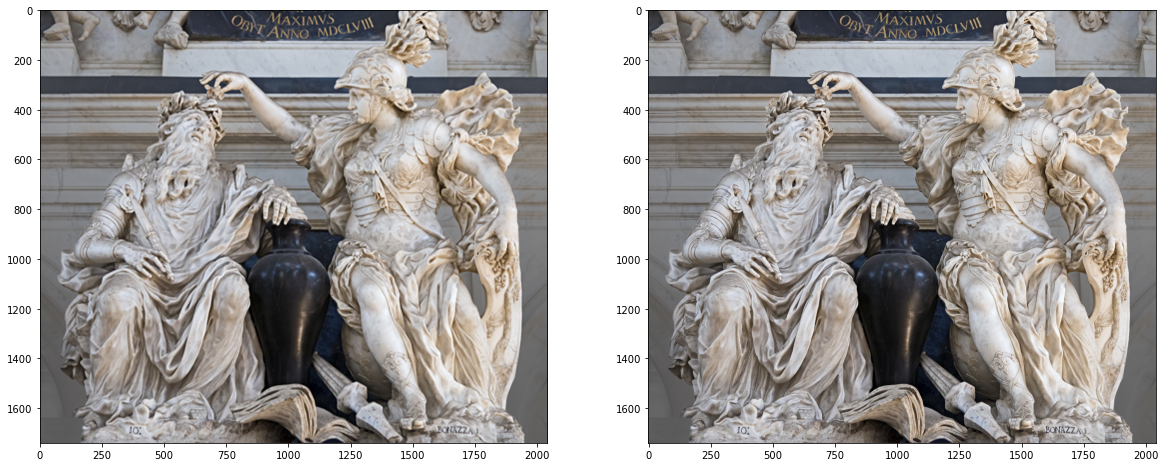

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

# 데이터를 불러옵니다.
train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True
)

# 시각화를 위해 한 개의 데이터만 선택합니다.
for i, (lr, hr) in enumerate(valid):
    if i == 6: break
    
# 저해상도 이미지를 고해상도 이미지 크기로 bicubic interpolation 합니다.  
hr, lr = np.array(hr), np.array(lr)
bicubic_hr = cv2.resize(
    lr, 
    dsize=(hr.shape[1], hr.shape[0]), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

# 저해상도 및 고해상도 이미지를 시각화 합니다.
plt.figure(figsize=(20,10))
plt.subplot(1,2,1); plt.imshow(bicubic_hr)
plt.subplot(1,2,2); plt.imshow(hr)

이미지 크기가 꽤 크기 때문에 어렴풋이 봐서는 선명함의 차이가 크지 않은 것 같습니다. 아래 코드를 이용해 각 이미지의 특정 부분을 확대해봅시다.



Text(0.5, 1.0, 'HR')

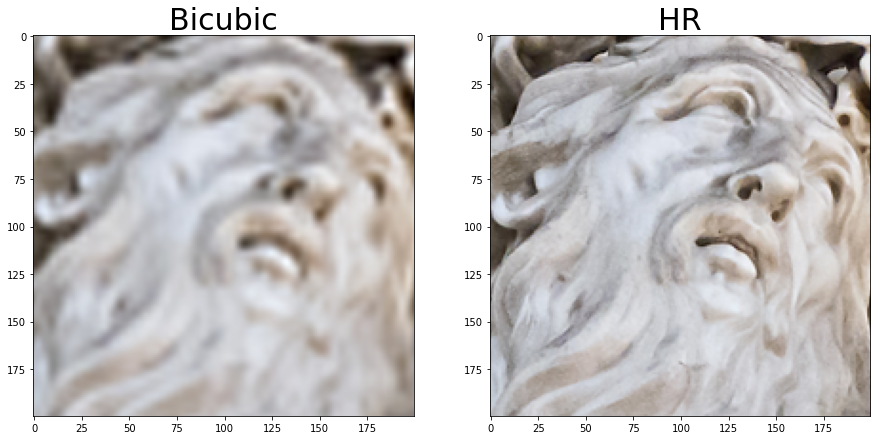

In [7]:
# 이미지의 특정 부분을 잘라내는 함수를 정의합니다.
def crop(image, left_top, x=200, y=200):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

# interpolation된 이미지와 고해상도 이미지의 동일한 부분을 각각 잘라냅니다.
left_top = (400, 500)
crop_bicubic_hr = crop(bicubic_hr, left_top)
crop_hr = crop(hr, left_top)

# 잘라낸 부분을 시각화 합니다.
plt.figure(figsize=(15,25))
plt.subplot(1,2,1); plt.imshow(crop_bicubic_hr); plt.title("Bicubic", fontsize=30)
plt.subplot(1,2,2); plt.imshow(crop_hr); plt.title("HR", fontsize=30)

Bicubic interpolation 방법을 이용한 결과는 HR이라 쓰여진 실제 고해상도 이미지와 비교하면 매우 선명하지 않은 것을 확인 할 수 있습니다. SRCNN을 이용해 학습한 결과는 얼마나 좋을지 아래에서 확인해 봅시다😆


앞서 언급되었듯이 SRCNN의 입력은 저해상도 이미지를 그대로 사용하는 것이 아닌, 만들고자 하는 고해상도 이미지 크기에 맞게 interpolation이 적용된 이미지입니다. 이 과정을 아래 코드와 같이 수행합니다. 사용할 DIV2K 데이터셋 내의 개별 이미지 크기가 크므로, 일부 영역을 임의로 잘라내어 학습에 활용해 보겠습니다.

In [8]:
import tensorflow as tf

def preprocessing(lr, hr):
    # 이미지의 크기가 크므로 (96,96,3) 크기로 임의 영역을 잘라내어 사용합니다.
    hr = tf.image.random_crop(hr, size=[96, 96, 3])
    hr = tf.cast(hr, tf.float32) / 255.
    
    # 잘라낸 고해상도 이미지의 가로, 세로 픽셀 수를 1/4배로 줄였다가
    # interpolation을 이용해 다시 원래 크기로 되돌립니다.
    # 이렇게 만든 저해상도 이미지를 입력으로 사용합니다.
    lr = tf.image.resize(hr, [96//4, 96//4], "bicubic")
    lr = tf.image.resize(lr, [96, 96], "bicubic")
    return lr, hr

train = train.map(preprocessing).shuffle(buffer_size=10).batch(16)
valid = valid.map(preprocessing).batch(16)
print("✅")

✅


### SRCNN 구현하기

앞서 살펴본대로 SRCNN은 3개 convolutional layer를 사용한 구조를 가지고 있습니다. 따라서 아래 코드와 같이 Sequential API를 활용해 간단하게 구현할 수 있습니다.

In [10]:
from tensorflow.keras import layers, Sequential

srcnn = Sequential()
srcnn.add(layers.Conv2D(128, 9, padding='same', input_shape=(None, None, 3)))
srcnn.add(layers.ReLU())
srcnn.add(layers.Conv2D(64, 5, padding='same'))
srcnn.add(layers.ReLU())
srcnn.add(layers.Conv2D(3, 5, padding='same'))

srcnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 128)   31232     
_________________________________________________________________
re_lu (ReLU)                 (None, None, None, 128)   0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    204864    
_________________________________________________________________
re_lu_1 (ReLU)               (None, None, None, 64)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 3)     4803      
Total params: 240,899
Trainable params: 240,899
Non-trainable params: 0
_________________________________________________________________


## SRCNN 학습하기

최적화 방법과 손실 함수를 설정하고, 앞서 전처리한 데이터를 이용해 아래와 같이 간단하게 학습할 수 있습니다. 우선 1 epoch만 학습시켜 봅시다.

In [11]:
srcnn.compile(
    optimizer = 'adam',
    loss = 'mse'
)

srcnn.fit(train, validation_data=valid, epochs=1)

50/50 [==============================] - 64s 1s/step - loss: 0.0236 - val_loss: 0.0091


### SRCNN 테스트하기

SRCNN의 학습에는 꽤나 오랜시간이 소요되어 여기서 SRCNN을 처음부터 끝까지 학습시키지 않겠습니다. 대신 SRCNN을 사용해보기 위해 이미 학습이 완료된 SRCNN 모델을 준비했습니다😅 아래 `srcnn.h5` 파일이 `./data` 폴더에 있ㅅ브니다. 다운로드 받은 후 코드를 실행하여 학습 완료된 모델을 불러올 수 있습니다.



In [12]:
import tensorflow as tf
import os

model_file = os.path.dirname(os.path.abspath("__file__")) + r'/data/srcnn.h5'
srcnn = tf.keras.models.load_model(model_file)

아래 코드와 같이 저해상도 이미지를 입력받아 SRCNN을 사용하는 함수를 간단하게 정의하고, 이 함수를 이용해 SRCNN의 결과인 고해상도 이미지를 얻어봅시다.



In [14]:
def apply_srcnn(image):
    sr = srcnn.predict(image[np.newaxis, ...]/255.)
    sr[sr>1] = 1
    sr[sr<0] = 0
    sr *= 255.
    return np.array(sr[0].astype(np.uint8))

srcnn_hr = apply_srcnn(bicubic_hr)

이전 bicubic interpolation을 적용하고 이미지 전체를 시각화 했을 때 세부적인 선명함이 눈에 띄지 않았기 때문에, 일부 영역을 잘라내어 시각적으로 비교해보겠습니다. 아래 코드를 이용해 3개 이미지(bicubic interpolation의 결과, SRCNN의 결과, 원래 고해상도 이미지)를 나란히 시각화합니다.



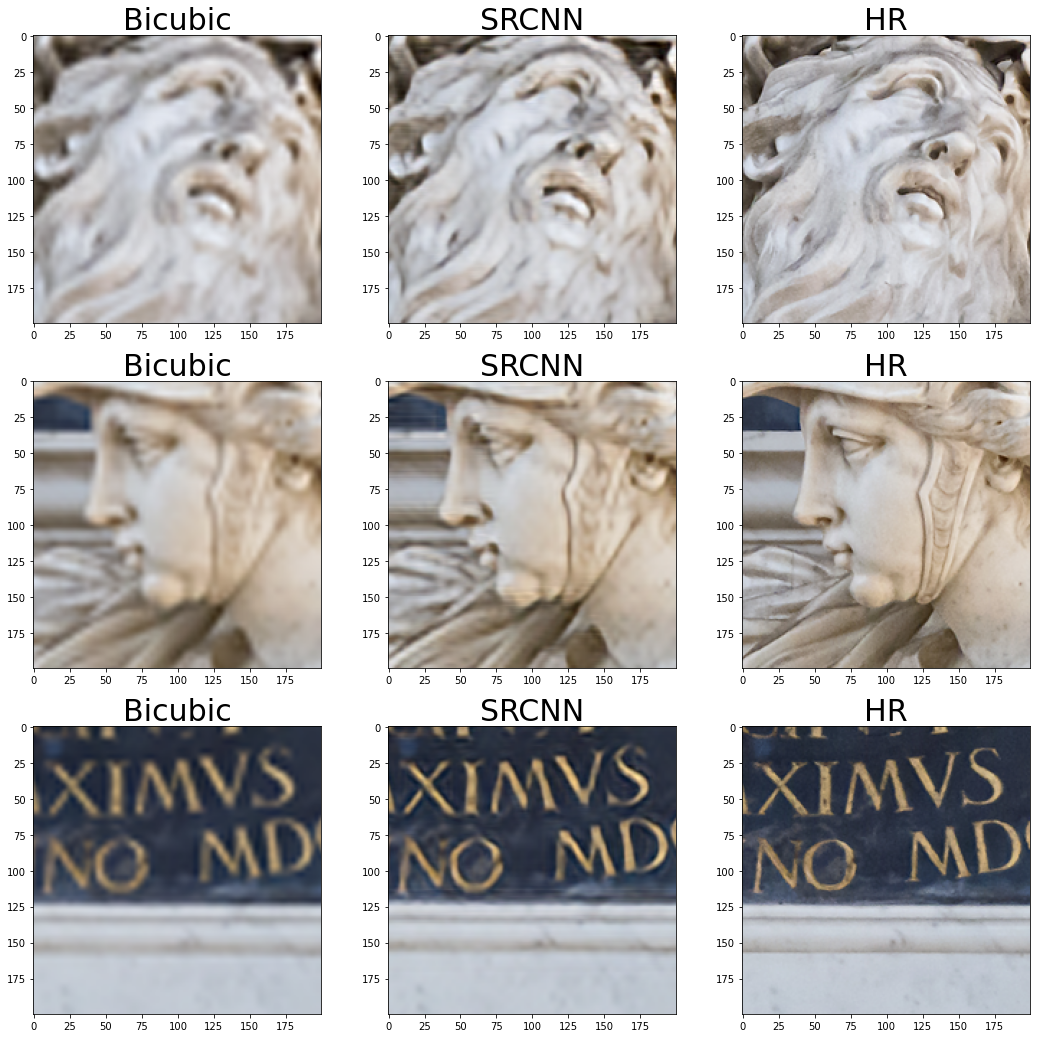

In [15]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(400,500), (300,1200), (0,1000)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srcnn_hr , left_top, 200, 200)
    img3 = crop(hr, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRCNN", "HR"] * 3

plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

시각화 결과 bicubic interpolation 결과보다 조금 더 선명해 졌지만 원래 고해상도 이미지에 비해 만족할만한 성능은 아닌 것 같습니다. DIV2K 데이터셋이 비교적 세밀한 구조의 이미지가 많아 SRCNN과 같이 간단한 구조로는 더 이상 학습되지 않는 것으로 보입니다.

실제로 SRCNN 논문에서는 아래와 같이 비교적 간단한 구조의 이미지에 대해서는 꽤나 만족할 만한 성능을 보여줍니다.

![img](https://aiffelstaticprd.blob.core.windows.net/media/images/e-22-13.srcnn_result.max-800x600.png)

다음 단계에서는 조금 더 강력한 모델에 대해서 알아보고 실험해봅시다.

## Deep Learning을 이용한 Super Resolution - (3) SRGAN

이번에는 GAN(Generative Adversarial Networks) 을 활용한 Super Resolution 과정에 대해 다뤄보려 합니다. 고해상도 이미지를 만들어 내는 데 GAN이 어떻게 활용될 수 있고, 이를 활용했을 때 어떠한 장점이 있는지 학습을 통해 알아봅시다.

### 다시 한번, GAN

이번 학습을 시작하기 전에 GAN을 대략적으로 알고 있다고 전제 했지만, GAN에 대해 다시 한번 가볍게 정리해 보겠습니다. 아래 참고 자료를 읽어봅시다.

- [새로운 인공지능 기술 GAN ① - 스스로 학습하는 인공지능](https://www.samsungsds.com/kr/insights/Generative-adversarial-network-AI.html?referrer=https://aiffelstaticprd.blob.core.windows.net/contents/CodeTemplate.html)
- [GAN - GAN의 개념과 이해](https://www.samsungsds.com/kr/insights/Generative-adversarial-network-AI-2.html?referrer=https://aiffelstaticprd.blob.core.windows.net/contents/CodeTemplate.html)

## SRGAN = Super Resoultion + GAN

최근 Super Resolution 분야에서 GAN은 매우 많이 활용되고 있습니다. 이번에는 가장 처음으로 Super Resolution에 GAN을 이용한 연구인 **SRGAN**에 대해 알아보겠습니다. SRGAN은 2016년 발표된 "Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network" 논문에서 제안되었으며, 아래 그림과 같이 이전에 학습한 SRCNN 보다 조금 복잡한 구조를 갖습니다. 논문 제목부터 "Photo-Realistic"이라 쓰여있으니 얼마나 좋은 결과가 나올지 기대가 됩니다🤔

![img](https://aiffelstaticprd.blob.core.windows.net/media/images/e-22-14.srgan.max-800x600.png)

그림의 Generator Network와 Discriminator Network는 각각 위에서 비유했던 위조지폐범(생성 모델)과 경찰(분류/판별 모델)입니다. Generator가 저해상도 이미지를 입력 받아 (가짜)고해상도 이미지를 생성해 내면, Discriminator는 생성된 (가짜)고해상도 이미지와 실제(진짜) 고해상도 이미지 중 진짜를 판별합니다.

Generator는 Discriminator를 속이려하고 Discriminator는 진짜를 가려내려는 학습이 진행될 수록 서로 경쟁자가 되어 둘 모두가 점점 발전합니다. 학습이 거의 완료 되면 최종적으로 Generator가 생성해낸 (가짜)고해상도 이미지는 Discriminator가 진짜인지 가짜인지를 구분하기 힘들 정도로 매우 좋은 품질을 가진 고해상도 이미지가 됩니다😁


SRGAN에서 사용하는 loss function은 아래와 같이 조금 특별합니다(?).

![img](https://aiffelstaticprd.blob.core.windows.net/media/images/e-22-15.srgan_loss.max-800x600.png)

위 식을 보면 크게 content loss와 adversarial loss로 구성되어 있고, 이 중 adversarial loss는 우리가 일반적으로 알고 있는 GAN의 loss이며, 조금 특별한 부분은 아래 그림으로 나타낸 content loss 부분 입니다.

![img](https://aiffelstaticprd.blob.core.windows.net/media/images/e-22-16.srgan_vgg.max-800x600.png)

`content loss`는 Generator를 이용해 얻어낸 (가짜) 고해상도 이미지를 실제 (진짜) 고해상도 이미지와 직접 비교하는 것이 아니라, 각 이미지를 이미지넷으로 사전 학습된(pre-trained) VGG 모델에 입력하여 나오는 feature map에서의 차이를 계산합니다.

즉, 이전에 학습했던 SRCNN은 생성해낸 고해상도 이미지를 원래 고해상도 이미지와 직접 비교하여 loss를 계산했지만, SRGAN에서는 생성된 고해상도 이미지와 실제 고해상도 이미지를 VGG에 입력하여 모델 중간에서 추출해낸 특징을 비교해서 loss를 계산합니다.

SRGAN은 VGG를 이용한 `content loss` 및 GAN을 사용함으로써 발생하는 adversarial loss를 합하여 최종적으로 **perceptual loss**라고 정의하며 이를 학습에 이용합니다.

이렇게 복잡한 손실 함수를 정의한 이유가 무엇일까요? 우선 다음 단계에서 SRGAN을 실험해 보고 이러한 손실 함수를 사용한 장점에 대해 다뤄보겠습니다

##  SRGAN을 이용해 Super Resolution 도전하기

SRCNN에 이어서 간략하게 알아본 SRGAN을 구현하고 실험해봅시다. 마찬가지로 이전 SRCNN에 사용했던 DIV2K 데이터셋을 사용합니다.

> SRCNN과 마찬가지로 아래에서 진행하는 SRGAN의 학습 과정은 간단한 과정만을 거치며 실제 SRGAN 논문에서 진행한 실험 과정과 세부적으로 차이가 있습니다. 이에 대한 자세한 내용은 SRGAN의 논문을 참고 바랍니다.



데이터 준비하기
SRCNN은 저해상도 이미지에 대해 interpolation하여 고해상도 이미지 크기로 맞춘 후 입력으로 사용했지만, SRGAN은 그러한 과정을 거치지 않습니다.

In [16]:
train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True
)

def preprocessing(lr, hr):
    hr = tf.cast(hr, tf.float32) /255.
        
    # 이미지의 크기가 크므로 (96,96,3) 크기로 임의 영역을 잘라내어 사용합니다.
    hr_patch = tf.image.random_crop(hr, size=[96,96,3])
        
    # 잘라낸 고해상도 이미지의 가로, 세로 픽셀 수를 1/4배로 줄입니다
    # 이렇게 만든 저해상도 이미지를 SRGAN의 입력으로 사용합니다.
    lr_patch = tf.image.resize(hr_patch, [96//4, 96//4], "bicubic")
    return lr_patch, hr_patch

train = train.map(preprocessing).shuffle(buffer_size=10).repeat().batch(8)
valid = valid.map(preprocessing).repeat().batch(8)
print("✅")

✅


### SRGAN 구현하기

먼저, 저해상도 이미지를 입력 받아 고해상도 이미지를 생성하는 Generator를 구현해 봅시다! SRGAN의 Generator 부분은 아래와 같습니다.

![img](https://aiffelstaticprd.blob.core.windows.net/media/images/e-22-17.srgan_gene.max-800x600.png)

그림 내의 `k9n64s1`라는 표기는 Convolutional layer 내의 hyperparameter 설정에 대한 정보이며, k는 kernel size, n은 사용 필터의 수, s는 stride를 나타냅니다. Tensorflow로 구현한다면 `Conv2D(filters=64, kernel_size=9, strides=1, padding="same")` 처럼 작성할 수 있습니다. 추가로 모든 stride가 1인 convolutional layer에는 패딩을 통해 출력의 크기를 계속 유지합니다.

SRGAN의 Generator에는 skip-connection을 가지고 있으며, 이는 Sequential API로 구현할 수 없으므로 Functional API를 이용해 아래와 같이 구현해 보겠습니다. 위 Generator 그림에서 각 layer를 따라 비교하면서 아래 코드를 이해해 봅시다.

